In [ ]:
import os
import tarfile
import urllib.request
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yolov5
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import torch
from PIL import Image
import cv2
import urllib.request
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import Callback


In [2]:
# Step 1: Download and extract the image dataset
dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
labels_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
data_dir = '/home/roi/Untitled_Folder/path/to/flower_dataset'
# Download and extract the dataset
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    urllib.request.urlretrieve(dataset_url, os.path.join(data_dir, '102flowers.tgz'))
    urllib.request.urlretrieve(labels_url, os.path.join(data_dir, 'imagelabels.mat'))
    tar = tarfile.open(os.path.join(data_dir, '102flowers.tgz'), 'r:gz')
    tar.extractall(data_dir)
    tar.close()
    print("Dataset downloaded and extracted successfully.")

In [3]:
# Step 2: Preprocessing
image_size = (224, 224)  # Resize images to (224, 224) for VGG19 and MobileNetV2

# Load image labels from .mat file
labels = loadmat(os.path.join(data_dir, 'imagelabels.mat'))
labels = labels['labels'][0]


In [4]:
# Split the dataset into training, validation, and test sets
X_train_val_index, X_test_index, y_train_val_index, y_test_index = train_test_split(np.arange(len(labels)), labels, test_size=0.25, random_state=42)
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_val_index, y_train_val_index, test_size=0.33, random_state=42)

In [5]:
# Define image preprocessing function
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [6]:
num_classes = len(np.unique(labels))
num_classes

102

In [7]:
# Preprocess training images
X_train = np.array([preprocess_image(data_dir + "/jpg/image_" + str(i + 1).zfill(5) + ".jpg") for i in X_train_index])
y_train = keras.utils.to_categorical(y_train_index - 1, num_classes=num_classes)

# Preprocess validation images
X_val = np.array([preprocess_image(data_dir + "/jpg/image_" + str(i + 1).zfill(5) + ".jpg") for i in X_val_index])
y_val = keras.utils.to_categorical(y_val_index - 1, num_classes=num_classes)

# Preprocess test images
X_test = np.array([preprocess_image(data_dir + "/jpg/image_" + str(i + 1).zfill(5) + ".jpg") for i in X_test_index])
y_test = keras.utils.to_categorical(y_test_index - 1, num_classes=num_classes)

## VGG19

In [8]:

class Callback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_acc = []

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        print(f'\nVGG19 Testing loss: {loss}, accuracy: {acc}\n')
        
test_callback = Callback((X_test, y_test))

In [9]:
# Load pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

2023-06-21 11:54:24.121985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [11]:

# Add a global average pooling layer and a fully connected layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

In [12]:
predictions = Dense(102, activation="softmax")(x)

In [13]:
os.system("taskset -p 0x3 {}".format(os.getpid()))

pid 25121's current affinity mask: ffff
pid 25121's new affinity mask: 3


0

In [14]:
# Create the VGG19 model
vgg19_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg19_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

vgg19_history = vgg19_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=50,
    epochs=5,
    callbacks=[test_callback],
)


Epoch 1/5


2023-06-21 11:54:44.888998: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2477088768 exceeds 10% of free system memory.


83/83 [==============================] - ETA: 0s - loss: 2.4338 - accuracy: 0.5321
VGG19 Testing loss: 0.9628088474273682, accuracy: 0.75

83/83 [==============================] - 1030s 13s/step - loss: 2.4338 - accuracy: 0.5321 - val_loss: 1.0022 - val_accuracy: 0.7356
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.9028
VGG19 Testing loss: 0.6833605170249939, accuracy: 0.818359375

83/83 [==============================] - 999s 12s/step - loss: 0.3754 - accuracy: 0.9028 - val_loss: 0.7584 - val_accuracy: 0.7953
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9643 
VGG19 Testing loss: 0.6403761506080627, accuracy: 0.8330078125

83/83 [==============================] - 1435s 17s/step - loss: 0.1494 - accuracy: 0.9643 - val_loss: 0.6831 - val_accuracy: 0.8170
Epoch 4/5
83/83 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9903
VGG19 Testing loss: 0.5652855038642883, accuracy: 0.8525390

In [15]:
# Evaluate VGG19 model
vgg19_scores_loss, vgg19_scores = vgg19_model.evaluate(X_test, y_test)
print("VGG19 Test Accuracy:", vgg19_scores)
print("VGG19 Test Loss:", vgg19_scores_loss)

64/64 [==============================] - 270s 4s/step - loss: 0.5208 - accuracy: 0.8662
VGG19 Test Accuracy: 0.8662109375
VGG19 Test Loss: 0.5207539200782776


In [16]:
column_names = vgg19_history.history.keys()
print(column_names)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


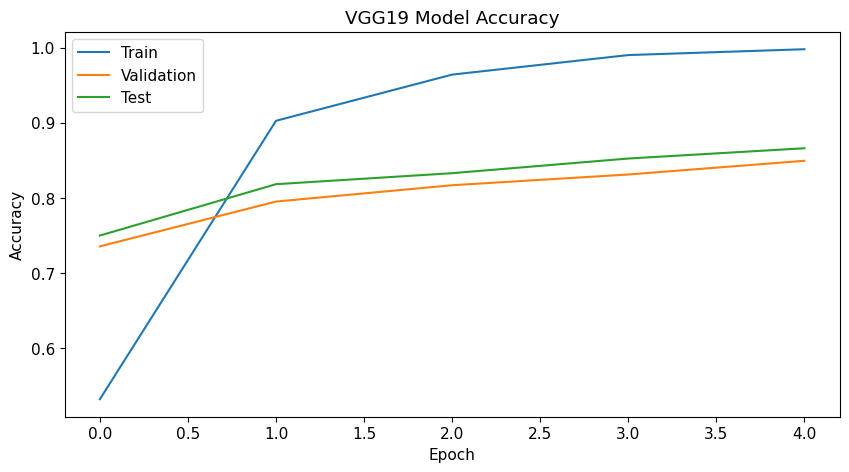

In [19]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(vgg19_history.history['accuracy'], label='Train')
plt.plot(vgg19_history.history['val_accuracy'], label='Validation')
plt.plot(test_callback.test_acc, label='Test')

plt.title('VGG19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

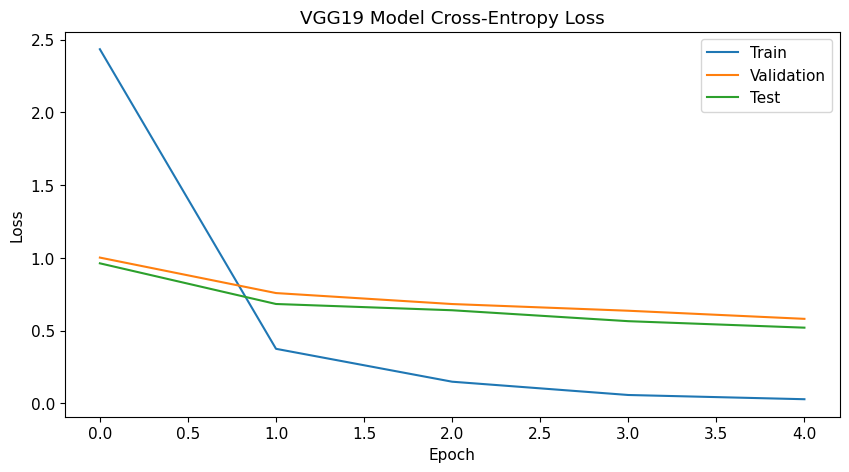

In [20]:
# Plot cross-entropy loss
plt.figure(figsize=(10, 5))
plt.plot(vgg19_history.history['loss'], label='Train')
plt.plot(vgg19_history.history['val_loss'], label='Validation')
plt.plot(test_callback.test_loss, label='Test')
plt.title('VGG19 Model Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## YOLOv5

In [22]:
import os
import requests
import tarfile
import scipy.io
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Download and extract the image dataset and labels
dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
labels_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
data_dir = '/home/roi/Untitled_Folder'

# Function to download a file from the internet
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# Download the image dataset and labels
download_file(dataset_url, os.path.join(data_dir, '102flowers.tgz'))
download_file(labels_url, os.path.join(data_dir, 'imagelabels.mat'))

# Extract the image dataset
with tarfile.open(os.path.join(data_dir, '102flowers.tgz'), 'r:gz') as tar:
    tar.extractall(path=data_dir)

# Load the labels
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0]

# Split the dataset into training, validation, and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    os.listdir(os.path.join(data_dir, 'jpg')), labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create the output directories
output_dir = '/home/roi/Untitled_Folder/datasets/flower_dataset'
os.makedirs(os.path.join(output_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'labels'), exist_ok=True)


In [23]:
from PIL import Image

# Function to move files and save labels
def move_files_and_save_labels(images, labels, split, output_dir):
    for image, label in zip(images, labels):
        # Move the image
        dest_path = os.path.join(output_dir, split, 'images', image)
        shutil.move(os.path.join(data_dir, 'jpg', image), dest_path)
        
        # Open the image and get its size
        with Image.open(dest_path) as img:
            img_width, img_height = img.size
        
        # Calculate the center, width and height
        x_center = img_width / 2.0
        y_center = img_height / 2.0
        width = img_width
        height = img_height

        # Normalize the center, width and height values
        x_center /= img_width
        y_center /= img_height
        width /= img_width
        height /= img_height
        
        # Save the label and coordinates
        with open(os.path.join(output_dir, split, 'labels', image.replace('.jpg', '.txt')), 'w') as f:
            f.write(f"{label} {x_center} {y_center} {width} {height}")

In [24]:
# Move the images and save the labels
move_files_and_save_labels(train_images, train_labels, 'train', output_dir)
move_files_and_save_labels(val_images, val_labels, 'val', output_dir)
move_files_and_save_labels(test_images, test_labels, 'test', output_dir)


In [33]:
import os
import numpy as np
import yaml

# Paths to train, val, and test image folders
train_folder = '/home/roi/Untitled_Folder/datasets/flower_dataset/train/images'
val_folder = '/home/roi/Untitled_Folder/datasets/flower_dataset/val/images'
test_folder = '/home/roi/Untitled_Folder/datasets/flower_dataset/test/images'

# Get unique class labels
unique_labels = np.unique(train_labels)

# Convert numpy scalar to regular Python scalar
def numpy_scalar_representer(dumper, data):
    return dumper.represent_scalar(u'tag:yaml.org,2002:float', str(data))

# Register the numpy scalar representer
yaml.add_representer(np.float32, numpy_scalar_representer)

# Create classes dictionary
classes = {idx: label.item() for idx, label in enumerate(unique_labels)}
classes[102] = 103
# Create data dictionary
data = {
    'path': '../datasets/flower_dataset',
    'train': train_folder,
    'val': val_folder,
    'test': test_folder,
    'names': classes
}

# Save data dictionary to YAML file
yaml_path = '/home/roi/Untitled_Folder/yolov5/data/data.yaml'  # Change the path as needed
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file)

print("Created data.yaml file")


Created data.yaml file


In [26]:
!python "/home/roi/Untitled_Folder/yolov5/train.py" --img 640 --epochs 3 --data data.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.9 torch-2.0.1+cu117 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, t

IOStream.flush timed out


        2/2         0G     0.0147    0.00805    0.07296         50        640:  

IOStream.flush timed out


        2/2         0G    0.01185   0.007189    0.07108          3        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all       1638       1638    0.00978      0.999     0.0161     0.0116

3 epochs completed in 1.708 hours.
Optimizer stripped from yolov5/runs/train/exp11/weights/last.pt, 14.9MB
Optimizer stripped from yolov5/runs/train/exp11/weights/best.pt, 14.9MB

Validating yolov5/runs/train/exp11/weights/best.pt...
Fusing layers... 
Model summary: 157 layers, 7287916 parameters, 0 gradients, 16.6 GFLOPs
                 Class     Images  Instances          P          R      mAP50   
                   all       1638       1638    0.00975      0.999     0.0157     0.0154
                     2       1638          5    0.00305          1    0.00433    0.00433
                     3       1638          9    0.00548          1    0.00698    0.00686
                     4       1638         10    0.00609          1    0.0084

In [30]:
!python "/home/roi/Untitled_Folder/yolov5/val.py" --img 640 --batch 16 --data data.yaml --weights "/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt"

val: data=/home/roi/Untitled_Folder/yolov5/data/data.yaml, weights=['/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.9 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7287916 parameters, 0 gradients, 16.6 GFLOPs
val: Scanning /home/roi/Untitled_Folder/datasets/flower_dataset/val/labels.cache
                 Class     Images  Instances          P          R      mAP50   
                   all       1638       1638    0.00976      0.999     0.0159     0.0156
Speed: 0.6ms pre-process, 95.4ms inference, 3.0ms NMS per image at shape (16, 3, 640, 640)
Results saved to yolov5/runs/val/exp6


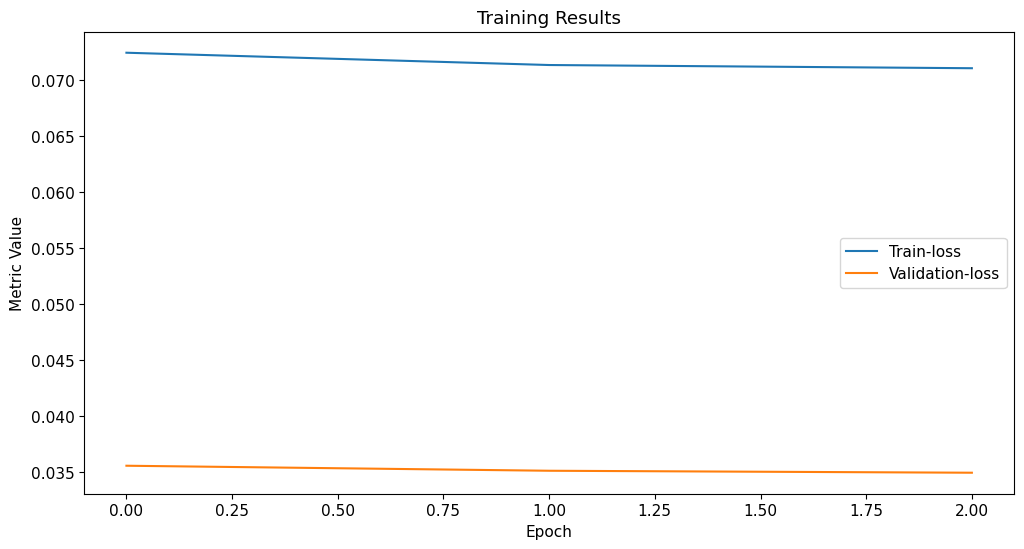

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from csv
data = pd.read_csv('/home/roi/Untitled_Folder/yolov5/runs/train/exp11/results.csv')

# Plot the data
plt.figure(figsize=(12,6))

# Assuming the CSV contains 'precision', 'recall' columns. Modify as needed.
plt.plot(data["      train/cls_loss"], label='Train-loss')
plt.plot(data["        val/cls_loss"], label='Validation-loss')

plt.title('Training Results')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.show()


In [34]:
!python "/home/roi/Untitled_Folder/yolov5/val.py" --task test --img 640 --batch 16 --data data.yaml --weights "/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt"

val: data=/home/roi/Untitled_Folder/yolov5/data/data.yaml, weights=['/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.9 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7287916 parameters, 0 gradients, 16.6 GFLOPs
test: Scanning /home/roi/Untitled_Folder/datasets/flower_dataset/test/labels... 
test: New cache created: /home/roi/Untitled_Folder/datasets/flower_dataset/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   
                   all       1638       1638    0.00979          1     0.0178     0.0167
Speed: 0.6ms pre-process, 81.9ms inference, 2.3ms NMS per image at shap

In [39]:
!python "/home/roi/Untitled_Folder/yolov5/val.py" --task test  --save-conf --img 640 --batch 16 --data data.yaml --weights "/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt"

val: data=/home/roi/Untitled_Folder/yolov5/data/data.yaml, weights=['/home/roi/Untitled_Folder/yolov5/runs/train/exp11/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-185-g2334aa7 Python-3.10.9 torch-2.0.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 7287916 parameters, 0 gradients, 16.6 GFLOPs
test: Scanning /home/roi/Untitled_Folder/datasets/flower_dataset/test/labels.cac
                 Class     Images  Instances          P          R      mAP50   
                   all       1638       1638    0.00979          1     0.0178     0.0167
Speed: 0.6ms pre-process, 79.6ms inference, 2.3ms NMS per image at shape (16, 3, 640, 640)
Results saved to yolov5/runs/val/exp8
